# Práctica 1. Algoritmos básicos de tratamiento digital de imágenes biomédicas

In [1]:
import numpy as np
import pydicom as pdc
import matplotlib.pyplot as plt
%matplotlib inline

## Ejercicio 1
Abrir la imagen o imágenes que le correspondan, creando una matriz de datos donde almacenar los valores de los píxeles. Una vez abierta, debe comprobar que los metadatos son correctos y determinar los parámetros básicos de la imagen, como el número de filas, columnas o número de bits por píxel. Describir el tipo de imagen obtenida (Radiología, TC, etc,) y su contenido anatómico (básico).

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 222
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.1032191849.1195185418.1268047576937.268.0
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'LASKER_11112'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SEQ']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.5962.99.1.1032191849.1195185418.1268047576937.268.0
(0008, 002

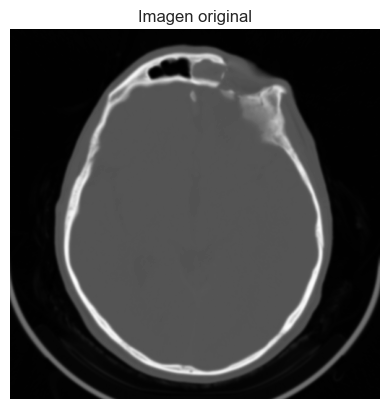

In [6]:
# Abrir la imagen
def abrir_imagen(num_imagen):
    return pdc.dcmread(f"./im{num_imagen}.dcm")

imagen = abrir_imagen(8)

# Metadatos de la imagen
print(imagen)

# Metadatos importantes
print("Bits por pixel:", imagen.BitsStored)
print("Modalidad:", imagen.Modality)
print("Descripción del estudio:",imagen.StudyDescription)
print("Numero de filas:", imagen.Rows)
print("Numero de columnas:", imagen.Columns)

# Guardar la imagen en una matriz de datos indicando los bits por pixel
def imagen_bits(imagen, bpp = 12):
    if bpp == 12:
        sol = np.array(imagen.pixel_array)
    elif bpp == 8:
        sol = (np.array(imagen.pixel_array) * (255/4095)).astype(np.uint8)
    return sol, bpp

# Guarda una imagen con 8 bpp y con un nombre
def guardar_8b(imagen, titulo):
    im = (np.array((imagen) * (255/4095))).astype(np.uint8)
    plt.plot(im)
    plt.show(False)
    plt.savefig(titulo)

# Creaamos la matriz de la imagen con 12 bpp
imagen_pixeles, bpp = imagen_bits(imagen, 12)

# Visualizamos la imagen
plt.imshow(imagen_pixeles, cmap = 'gray') # cmap = "gray", camp = "jet", cmap = "viridis"
plt.axis('off')
plt.title("Imagen original")
plt.show()

#print(imagen.group_dataset(0x0008))
#plt.imsave(r"C:\Users\Gonzalo_MA\Desktop\Universidad\Tercero\Imagenes biomedicas\Practica 1\images\Imagen original.jpg", imagen_pixeles, cmap = "gray")

## Ejercicio 2
Realizar el cálculo del histograma de dos formas independientes y visualizarlo en un gráfico de forma óptima (de forma que se vean con claridad los picos que corresponden a las zonas de interés de la imagen, que podrán ser identificadas, para lo que deberá definir los valores de los rangos adecuados en los ejes x e y):
- Utilizando la rutina imhist(…) de Matlab (con los parámetros adecuados).
- Mediante un algoritmo que deberá programar, que obtenga un resultado similar al de la rutina de Matlab (aquí intentamos aprender a programar nosotros mismos lo mismo que hace Matlab).
Nota: bins es el nombre que se da en estadística al número de intervalos (variable aleatoria discreta) en que se divide el rango de la variable (en este caso, el nivel de gris) para calcular el histograma.

### Primera forma (imshow)

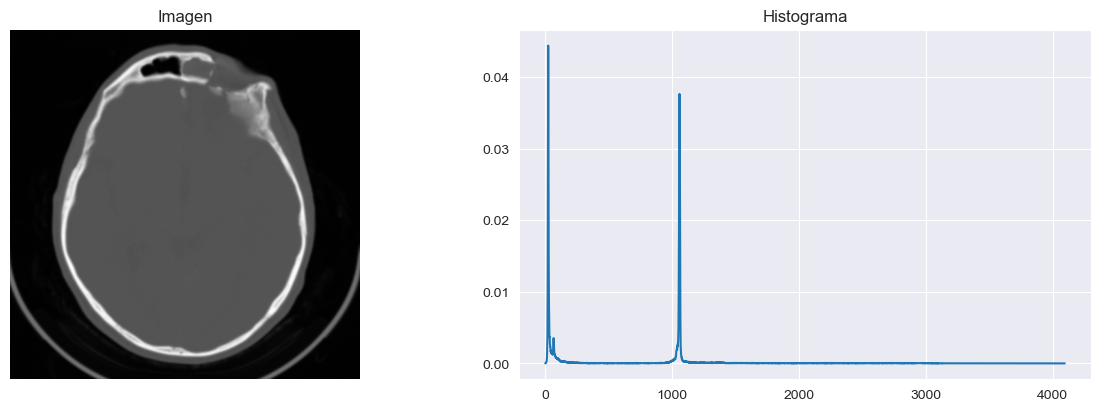

In [19]:
def histograma_1(imagen, zoom_min = 0, zoom_max = (2**bpp)-1):
    # Creamos el histograma
    histogram, bins = np.histogram(imagen.flatten(), bins = 2**bpp, range = (0, 2**bpp), density = True)
    # Visualizamos las imágenes
    fig, ax = plt.subplots(1, 2, figsize = (12, 4), layout = "constrained")
    ax[0].imshow(imagen_pixeles, cmap = "gray")
    ax[0].axis("off")
    ax[0].set_title("Imagen")
    ax[1].plot(bins[:-1], histogram)
    ax[1].set_title("Histograma")
    # Zoom
    if zoom_min != 0 or zoom_max != (2 ** bpp)-1:
        ax[1].set(xlim=(zoom_min, zoom_max))

histograma_1(imagen_pixeles)

### Segunda forma (a mano)

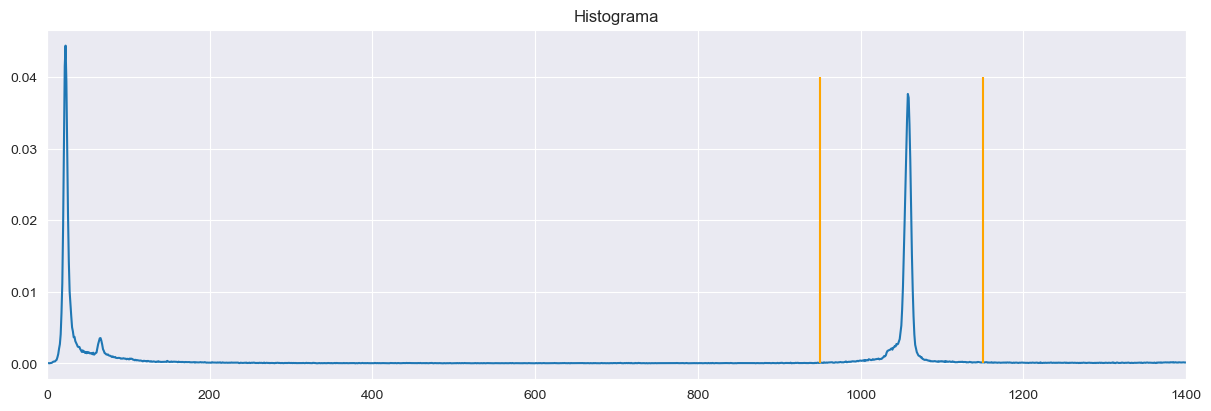

In [20]:
def histograma_2(imagen, zoom_min = 0, zoom_max = (2**bpp)-1):
    # Calculamos las veces que aparece cada valor
    valores, cuenta = np.unique(imagen.flatten(), return_counts= True)
    # Pasamos a frecuencias relativas
    cuenta = cuenta/(512*512)
    # Visualizamos las imágenes
    _, ax = plt.subplots(figsize = (12, 4), layout = "constrained")
    ax.plot(valores, cuenta)
    ax.set_title("Histograma")
    #plt.savefig("histograma.jpg", format = "jpg")
    # Zoom
    if zoom_min != 0 or zoom_max != (2 ** bpp)-1:
        ax.set(xlim=(zoom_min, zoom_max))
    
# Dibuja una linea vertical 
def linea(arg):
    plt.vlines(x = arg, ymin = 0, ymax = 0.04, colors = "orange")

histograma_2(imagen_pixeles, 0, 1400)
linea(950)
linea(1150)

## Ejercicio 3
Visualizar la parte más significativa de la información contenida en la imagen que te corresponda, mediante la selección de la ventana idónea en cada caso. Para cada imagen (según el número de la imagen que le ha sido asignada), la región de interés es:
1. Estructura ósea
2. Hígado
3. Hueso
4. Tejido graso/microcalcificaciones vasculares
5. Tumor y masa cerebral
6. Estructura ósea
7. Parénquima pulmonar
8. Tejido cerebral
9. Tejido graso
10. Organos

Se recomienda usar el comando imshow(…). Tenga en cuenta que la mayoría de las imágenes médicas tienen un tipo de datos uint16 que permite más de 256 niveles de gris. La visualización es adecuada si la región de interés se muestra con un contraste adecuado y puede apreciarse con nitidez el órgano o estructura de interés.

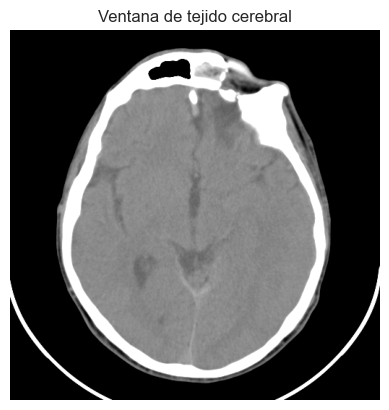

In [14]:
# Para el tejido cerebral los valores optimos son 950 / 1150 (bpp = 12)
# Para el tejido cerebral los valores optimos son 57 / 75 (bpp = 8)
# Para la ventana osea los valores optimos son 1100 / 4000 (bpp = 12)
def ventana(imagen, vmin, vmax):
    # Valores por debajo del min puestos a 0
    # Valores por encima del max puestos puestos al valor max del tipo de datos
    clipeada = np.clip(imagen, a_min=vmin, a_max=vmax)
    # Reescalamiento para que la ventana ocupe todos los valores de píxeles
    clipeada = ((clipeada - vmin)/(vmax - vmin))*((2**bpp)-1)
    # Visualización
    _, ax = plt.subplots()
    ax.imshow(clipeada, cmap = "gray")
    ax.axis("off")
    ax.set_title("Ventana de tejido cerebral")
    #plt.savefig("ventana cerebral.jpg", format = "jpg")
    #clipeada2 = np.clip(imagen, a_min = 1100, a_max= 4000)
    #clipeada2 = ((clipeada2 - 1100)/(4000 - 1100))*((2**bpp)-1)
    
    #ax[1].imshow(clipeada2, cmap = "gray")
    #ax[1].axis("off")
    #ax[1].set_title("Ventana osea")
    #return ax
ventana(imagen_pixeles, 950, 1150)

## Ejercicio 4
Transformar la imagen, de forma que se mantenga la visualización de la parte más significativa de la información de interés (ver apartado anterior) contenida en la imagen. Este tipo de algoritmos modifican el contraste de la imagen, eligiendo una ventana del rango de niveles de gris original y convirtiendo esos niveles de gris en el rango completo de niveles de gris, para mejorar su visualización subjetiva. Para la modificación del contraste, deberá utilizar:
1. La función imadjust(…) de Matlab.
Los algoritmos a emplear son:
> 1. Negativo de la imagen.
>  2. Corrección gamma=2.
>  3. Ajuste y=sqrt(x).
>  4. Ajuste lineal a una ventana óptima (se entiende que eligiendo el rango de niveles de gris de interés para la visualización del órgano o estructura de interés).
>  5. Ajuste lineal a un rango de entrada comprendido entre los percentiles 5% y el 95% de los niveles de gris. (El rango inferior es el nivel de gris para el cual un máximo del 5% de los píxeles no superan dicho nivel de gris, lo mismo con el rango superior en el 95%). Para calcular los valores de nivel de gris que corresponden a los percentiles 5% y 95%, puede usar el histograma calculado en el apartado 2.

2. De los cinco algoritmos anteriores, indique cuál es que ofrece una mejor visualización, según su criterio subjetivo.
3. Deberá programar un algoritmo propio que obtenga un resultado similar al de la rutina de Matlab imadjust (sólo la opción, de entre las cinco, con la que se obtiene la mejor visualización).

### Negativo de la imagen

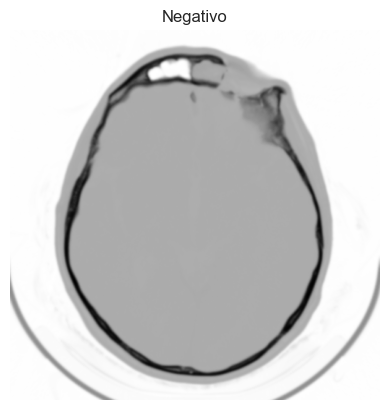

In [15]:
def negativo(imagen):
    neg = ((2**bpp)-1) - imagen
    _, ax = plt.subplots()
    ax.imshow(neg, cmap = "gray")
    ax.axis("off")
    ax.set_title("Negativo")
    #plt.savefig("negativo.jpg", format = "jpg")
negativo(imagen_pixeles)

### Correccion de gamma

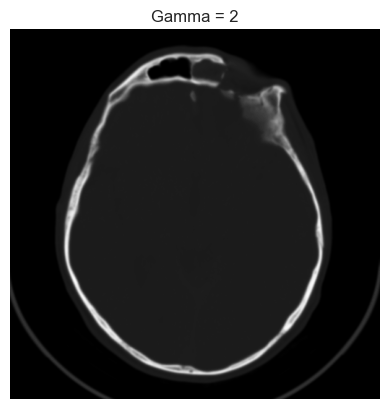

In [16]:
def gamma_1(imagen, nivel):
    _, ax = plt.subplots()
    ax.imshow(((imagen/((2**bpp)-1))**nivel)*((2**bpp)-1), cmap = "gray")
    ax.axis("off")
    ax.set_title(f"Gamma = {nivel}")

def gamma_2(imagen, nivel):
    potencias = (np.arange((2**bpp)-1)/((2**bpp)-1))**nivel
    def buscar(valor):
        return potencias[valor]
    func = np.vectorize(buscar)
    _, ax = plt.subplots()
    ax.imshow(func(imagen), cmap = "gray")
    ax.axis("off")
    ax.set_title(f"Gamma = {nivel}")
    #plt.savefig("gamma2.jpg", format = "jpg")
    
gamma_2(imagen_pixeles, 2)

### Ajuste y = sqrt(x)

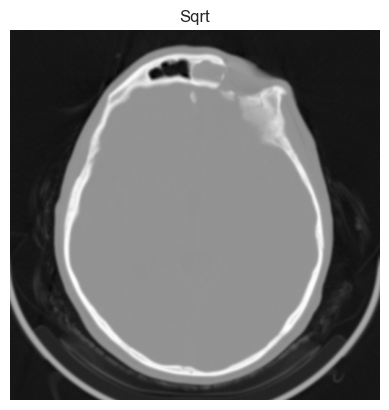

In [17]:
def ajuste_sqrt(imagen):
    _, ax = plt.subplots()
    ax.imshow(np.sqrt(imagen), cmap = "gray")
    ax.axis("off")
    ax.set_title("Sqrt")
    #plt.savefig("sqrt.jpg", format = "jpg")
ajuste_sqrt(imagen_pixeles)

### Ventana lineal

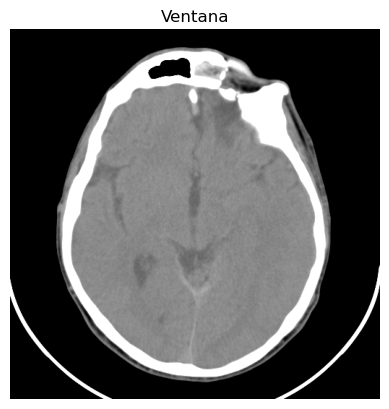

In [24]:
# Para el tejido cerebral los valores optimos son 950 / 1150 (bpp = 12)
# Para el tejido cerebral los valores optimos son 57 / 75 (bpp = 8)

ventana(imagen_pixeles, 950, 1150)
plt.savefig("ventana.png")

### Ajuste lineal entre percentiles

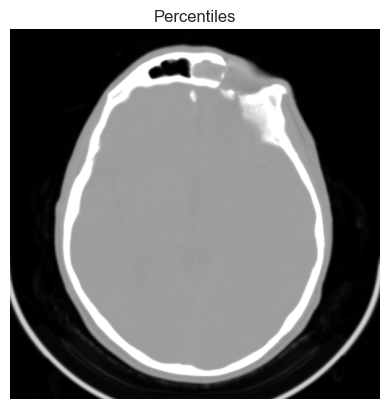

In [18]:
def percentil(imagen, down_perce = 5, up_percen = 95):
    down, up = np.percentile(imagen, [down_perce, up_percen])
    ventana(imagen, vmin= down, vmax=up)
    plt.title("Percentiles")
    #plt.savefig("percentiles.jpg", format = "jpg")
percentil(imagen_pixeles)

## Imagen extra para el informe

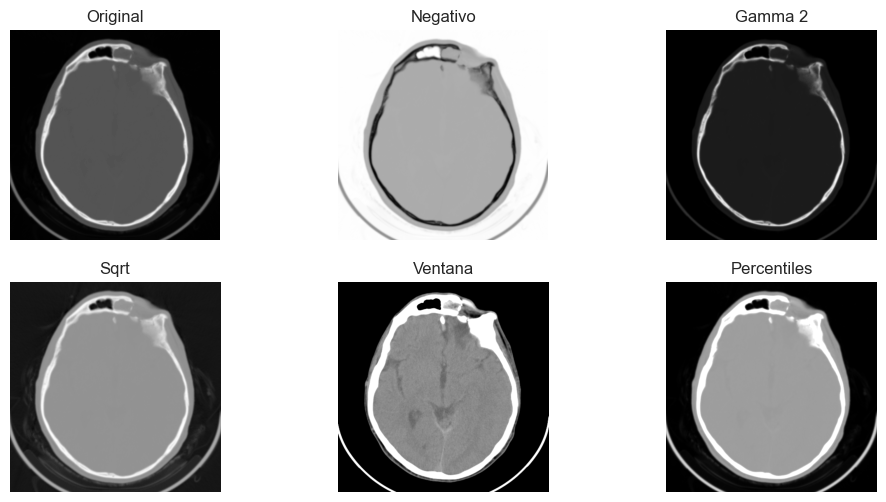

In [25]:
fig, ax = plt.subplots(2, 3, figsize = (12, 6))

ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Original")
ax[0,1].imshow(((2**bpp)-1) - imagen_pixeles, cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Negativo")
ax[0,2].imshow(((imagen_pixeles/((2**bpp)-1))**2)*((2**bpp)-1), cmap = "gray")
ax[0,2].axis("off")
ax[0,2].set_title("Gamma 2")

ax[1,0].imshow(np.sqrt(imagen_pixeles), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Sqrt")

clipeada = np.clip(imagen_pixeles, a_min=950, a_max=1150)
clipeada = ((clipeada - 950)/(1150 - 950))*((2**bpp)-1)
ax[1,1].imshow(clipeada, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Ventana")

down, up = np.percentile(imagen_pixeles, [5, 95])
clipeada = np.clip(imagen_pixeles, a_min=down, a_max=up)
clipeada = ((clipeada - down)/(up - down))*((2**bpp)-1)
ax[1,2].imshow(clipeada, cmap = "gray")
ax[1,2].axis("off")
ax[1,2].set_title("Percentiles")
plt.show()

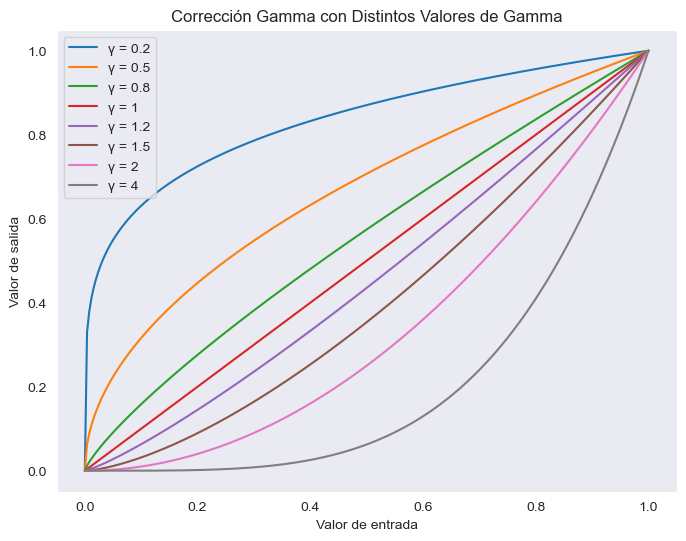

In [33]:
x = np.linspace(0, 1, 256)
# Definir valores de gamma para la corrección gamma
gammas = [0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 4]

# Crear una figura y ejes para la gráfica
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Iterar a través de diferentes valores de gamma y graficar las curvas
for gamma in gammas:
    y = x ** gamma
    label = f'γ = {gamma}'
    ax2.plot(x, y, label=label)

# Configurar propiedades del gráfico
ax2.set_xlabel('Valor de entrada')
ax2.set_ylabel('Valor de salida')
ax2.set_title('Corrección Gamma con Distintos Valores de Gamma')
ax2.legend(loc='upper left')

# Mostrar la gráfica
plt.grid()
plt.show()